In [1]:
import json
import bz2
import re
from tqdm import tqdm
from scipy import sparse

# Классификация по тональности

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:21, 2467.23it/s]



Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [5]:
len(responses)

153499

## Подготовка данных

In [6]:
data = pd.DataFrame(responses)

In [7]:
data_classification = data[ (data['rating_grade'] == 1) | (data['rating_grade'] == 5) ]

In [8]:
data_classification = data_classification[['text', 'rating_grade']]

In [9]:
data_classification.head(3)

,text,rating_grade
19,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,"05.06.2015г. около 15 часов, пришел в указанны...",1.0


In [10]:
data = data.dropna(how = 'any')

In [11]:
data.sample(10)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
103351,г. Москва,False,Ошибка была в выгрузке,0,лицензия № 2268,outcrew,МТС Банк,2012-08-13 17:04:00,08.08.12 по зарплатному проекту мне была переч...,3.0
122051,г. Москва - Ростов-на-Дону,False,Сбербанк онлайн и оплата кредита,14,лицензия № 1481,Khopryachkoff,Сбербанк России,2011-07-05 20:14:00,Доброго времени суток! Надеюсь получить вразум...,1.0
118235,г. Москва,False,Интернет-банк: реклама и действительность!,1,лицензия № 316,ARNik,Хоум Кредит Банк,2011-10-18 17:08:00,Решил открыть в ХК депозит. Понравились услови...,2.0
72349,г. Москва,False,Изготовление карты,0,лицензия № 3251,Shmity,Промсвязьбанк,2013-09-27 17:15:00,31 августа подал заявку через интернет банк на...,3.0
106136,г. Москва,False,"Кому противно или стыдно обслуживать, пусть ра...",22,лицензия № 2289,movex,Русский Стандарт,2012-06-20 18:03:00,"Добрый день. Как говорится, театр начинается с...",1.0
79061,г. Екатеринбург,False,Транспортная карта,3,лицензия № 2289,yulizarina,Русский Стандарт,2013-07-15 18:20:00,В январе 2013г. в г.Екатеринбург завела дебето...,1.0
99896,г. Москва,False,Конфиденциальные данные клиентов под угрозой...,2,лицензия № 2241,Mr.Baxter,Киви Банк,2012-10-11 16:23:00,"Ужасный сервис, как в итоге оказалось. Сейчас ...",1.0
131488,г. Москва,False,Немного позитива,9,лицензия № 3292,Drebin,Райффайзенбанк,2010-09-01 17:20:00,"Похоже, довольные клиенты нечасто оставляют св...",4.0
9721,г. Москва,False,Наглое воровство денег у клиента,12,лицензия № 3065,neonfit,Военно-Промышленный Банк,2015-03-14 14:46:00,"Добрый день, уважаемые banki.ru! Хочу рассказа...",4.0
53630,г. Москва,False,Поддержка на двойку,1,лицензия № 316,Irina C,Хоум Кредит Банк,2014-03-21 11:10:00,Имею вклад в ХКФ. К нему есть карта. Карта зак...,1.0


### Подготовим названия городов

In [12]:
# Создадим список городов России

city = pd.read_csv('https://raw.githubusercontent.com/hflabs/city/master/city.csv')

In [13]:
city_ = [address.split('г ')[1].lower() for address in city['address']]
len(city_)

1117

In [14]:
# Преобразуем названия городов к простому виду: все названия с маленькой буквы
# и заменяем сокращения на полные названия.
# Маркеруем города без названий как unknown.

def get_city_name(string):
    # шаблон поиска
    city_pattern = r'[йцукенгшщзхъфывапролджэёячсмитьбю-]{3,}'
    
    # варианты названий
    spb = ['с-петербург', 'спб', 'с-пб', 'петербург', 'питер', 'spb', 'saint peterburg', 'st.peterburg', '-пб', '-петербург']
    msk = ['мск', 'msk', 'moscow']
    
    # переводим все названиия в строчные для удобства анализа.
    city = re.findall(city_pattern, string)
    if len(city) == 0:
        return 'unknown'
    elif city in spb:
        return 'санкт-петербург'
    elif city in msk:
        return 'москва'
    else:
        return city[0]

In [15]:
# Приводим названия городов к табличным.

def mark_wrong_names(string):
    if string in city_:
        return string
    else:
        return 'wrong_name'

In [16]:
# Т.к. не везде в отзывах указан город, заменяем None на unknown

data['city'].fillna(value='unknown', inplace=True)

In [17]:
data['city'].unique()

array(['г. Москва', 'г. Ростов-на-Дону', 'г. Санкт-Петербург', ...,
       'г. Москва, павелецкое отделение', 'г. Москва-Владимир',
       'г. Краснодарский край, ст.Павловская'], dtype=object)

In [18]:
# Переведём все в нижний регистр, для простоты.

data['city'] = data['city'].apply(lambda x : x.lower())
data['text'] = data['text'].apply(lambda x : x.lower())

In [19]:
data['city'].unique()

array(['г. москва', 'г. ростов-на-дону', 'г. санкт-петербург', ...,
       'г. москва, павелецкое отделение', 'г. москва-владимир',
       'г. краснодарский край, ст.павловская'], dtype=object)

In [20]:
# Избавляемся от буквы г перед названием города и сокращений типа Мск.

data['city'] = data['city'].apply(get_city_name)

In [21]:
data['city'] = data['city'].apply(mark_wrong_names)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74710 entries, 14 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                74710 non-null  object 
 1   rating_not_checked  74710 non-null  bool   
 2   title               74710 non-null  object 
 3   num_comments        74710 non-null  int64  
 4   bank_license        74710 non-null  object 
 5   author              74710 non-null  object 
 6   bank_name           74710 non-null  object 
 7   datetime            74710 non-null  object 
 8   text                74710 non-null  object 
 9   rating_grade        74710 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 5.8+ MB


In [23]:
# Удаляем цифры в комментариях.

digits = r'[0-9]'
data['text'] = data['text'].apply(lambda text : re.sub(digits, '', text))

In [24]:
# Подсчитаем колличество символов и слов в коментариях.

data['words'] = data['text'].apply(lambda x : len(x.split(' ')))
data['simbols'] = data['text'].apply(lambda x : len(x))

In [25]:
# Итоговый набор данных.

summary = data[['city', 'bank_name', 'rating_grade', 'text', 'words', 'simbols']]

In [26]:
summary.head()

,city,bank_name,rating_grade,text,words,simbols
14,москва,Тинькофф Банк,2.0,"также как и многие давний клиент банка, был до...",245,1633
19,москва,Сбербанк России,1.0,открыт вклад и счет в usd. плюс к этому есть з...,339,2180
33,ростов-на-дону,Сбербанк России,1.0,доброго времени! вчера мне поступило смс-уведо...,313,2147
76,санкт-петербург,АктивКапитал Банк,1.0,"..г. около часов, пришел в указанный офис с н...",184,1249
85,москва,Сбербанк России,1.0,для оплаты коммунальных платежей пользуюсь пла...,56,392


In [27]:
# summary.groupby(['city', 'bank_name'])['text'].count().sort_values(by='words', ascending=False)

In [28]:
# загружаем пунктуацию и стоп-слова

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/serge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/serge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [31]:
noise = stopwords.words('russian') + list(punctuation) + ['...', '..', '``', "''", '«', '»', ' ', '\n']

### Лемитизация

In [32]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

In [33]:
def get_lemm_string(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return " ".join([word for word in text if word not in noise])

In [34]:
get_lemm_string(summary['text'][14])

'также многий давний клиент банк довольный высокий степень сколько друг знакомый приводить    сосчитать большинство сотрудник компания переходить зарплатный проект тинькофф практически весь друг заводить карта вклад твориться последний время просто шокировать    унификация вклад страшный сон мочь присниться мочь снижать процент пополнение вклад       ответ пункт читать мочь разрешать беспроцентный закрывать вклад который открывать хотя апрель сильный снижение декабрь поверять банка становиться открывать банк выгодный процент совкомбанк пример менее надежный банк давать       учет налог \xa0   замечать отзыв удалять неугодный комментарий касаться понижение ставка ответ представитель банк полугодовой давность недопустимость снижение ставка пополнение портал вопросответ информация также стереть отключать дистанционный обслуживание \xa0   сегодня подавать заявка выпуск карта all airlines сообщать выпускать самый близкий времякрайний срок    понедельник закрывать текущий карта час связывать

In [35]:
# Составим сборник из текстов после лематизации.

text_lemm = summary['text'].apply(get_lemm_string)

In [36]:
text_lemm

14        также многий давний клиент банк довольный высо...
19        открывать вклад счет usd плюс это зарплатный к...
33        добрый время вчера поступать смсуведомление ба...
76        г около    час приходить указанный офис намере...
85        оплата коммунальный платеж пользоваться пласти...
                                ...                        
138574    являться вкладчик павловский осб №    югозапад...
138576    май    год вносить    тыс руб банкомат вр конв...
138578    почитать отзыв свой банк карта который рука … ...
138585    кража карта предыдущий банк gemoney решать вос...
138946    здравствовать закрывать карта метро номер     ...
Name: text, Length: 74710, dtype: object

## Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [37]:
summary.groupby(['city', 'bank_name'])['text'].count().sort_values(ascending=False)

city             bank_name       
москва           Сбербанк России     4779
                 Альфа-Банк          2108
                 Русский Стандарт    1712
                 ВТБ 24              1579
санкт-петербург  Сбербанк России     1430
                                     ... 
ахтубинск        Хоум Кредит Банк       1
                 Экспресс-Волга         1
ачинск           Альфа-Банк             1
                 БНП Париба Банк        1
ярцево           Хоум Кредит Банк       1
Name: text, Length: 7445, dtype: int64

2. Постройте гистограмы длин слов в символах и в словах

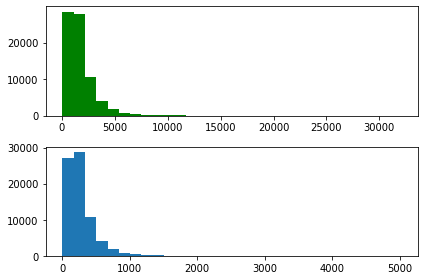

In [38]:
fig, axs = plt.subplots(2, 1)
axs[0].hist(summary['simbols'], bins=30, color='g')
axs[1].hist(summary['words'], bins=30)
fig.tight_layout()
plt.show()

3. Найдите 10 самых частых:
* слов
* слов без стоп-слов
* лемм
* существительных

In [39]:
from collections import Counter
corpus_words = [token for text in summary.text for token in word_tokenize(text) if token not in noise]

In [40]:
freq_word = Counter(corpus_words)

In [41]:
# 10 самых частых слов без стоп-слов
freq_word.most_common(20)

[('банка', 145885),
 ('банк', 103930),
 ('это', 101938),
 ('деньги', 72195),
 ('карту', 61282),
 ('карты', 56887),
 ('отделение', 42771),
 ('день', 41895),
 ('заявление', 40584),
 ('кредит', 39438),
 ('время', 38036),
 ('очень', 36960),
 ('банке', 35998),
 ('дней', 33337),
 ('счет', 32120),
 ('года', 29737),
 ('карта', 29215),
 ('вопрос', 28096),
 ('ответ', 27398),
 ('г.', 27213)]

Очевидно что 'банка', 'банк' и 'банке' должны быть объеденены в одну группу.

In [42]:
corpus_lemm = [token for text in text_lemm for token in word_tokenize(text) if token not in noise]

In [43]:
# 10 самых частых лемм
freq_lemm = Counter(corpus_lemm)
freq_lemm.most_common(20)

[('банк', 315487),
 ('карта', 188509),
 ('это', 130266),
 ('деньги', 99153),
 ('день', 98834),
 ('отделение', 92445),
 ('который', 83145),
 ('сотрудник', 79525),
 ('счет', 78866),
 ('весь', 77813),
 ('кредит', 76551),
 ('клиент', 74083),
 ('мочь', 71036),
 ('сказать', 67783),
 ('свой', 65428),
 ('получать', 60977),
 ('заявление', 59985),
 ('сумма', 57731),
 ('вопрос', 56347),
 ('год', 55012)]

4. Постройте кривые Ципфа и Хипса

    4.1 Ципф

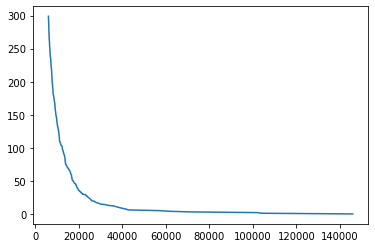

In [45]:
freqs = list(freq_word.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

    4.2 Хипс

In [46]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in noise])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 74710/74710 [05:26<00:00, 228.75it/s]


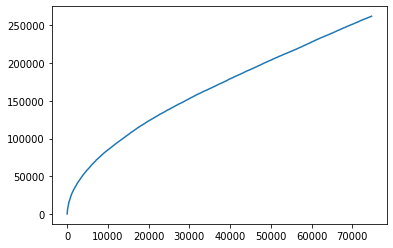

In [47]:
fig, ax = plt.subplots()
ax.plot(n_words)
plt.show()

5. Ответьте на следующие вопросы:
* какое слово встречается чаще, "сотрудник" или "клиент"?
* сколько раз встречается слова "мошенничество" и "доверие"?

In [48]:
# какое слово встречается чаще, "сотрудник" или "клиент"?
freq_lemm['сотрудник'] > freq_lemm['клиент']

True

In [49]:
# сколько раз встречается слова "мошенничество" и "доверие"?
freq_lemm['мошенничество'], freq_lemm['доверие']

(1186, 1098)

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [51]:
# cuted = summary[ (summary['rating_grade'] == 1) | (summary['rating_grade'] == 5) ].sample(1000)
cuted = summary[ (summary['rating_grade'] == 1) | (summary['rating_grade'] == 5) ]

In [52]:
cuted['rating_grade'].value_counts()

1.0    39855
5.0    10511
Name: rating_grade, dtype: int64

In [53]:
# sns.scatterplot(x=cutevalue_counts, y=cuted['simbols'], hue=cuted['rating_grade'])

In [54]:
vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'), max_df=0.8, min_df=4)

In [55]:
tfidf_pos = vec.fit_transform(cuted[ cuted['rating_grade'] == 5 ]['text'])

In [56]:
tfidf_neg = vec.fit_transform(cuted[ cuted['rating_grade'] == 1 ]['text'])

In [57]:
tfidf_pos.shape, tfidf_neg.shape

((10511, 26752), (39855, 54954))

In [58]:
# Значение из словаря по индексу.

def get_term(dictionary, index):
    for key, value in dictionary.items():
        if value == index:
            return key

In [59]:
# Вычисляем 10 самых используемых лемм в отрицательных отзывах.
# Приводим TF-IDF к матрице типа dense.
# Сортируем по возростанию и отрезаем 5 наиболее характерных.
# Вытягиваем полученные индексы в ленту.

index_tape_pos = tfidf_pos.todense().argsort()[:,-5:].flatten().tolist()[0]

In [60]:
# Вычисляем 10 самых распрастранёных.

Counter([ get_term(vec.vocabulary_, index) for index in index_tape_pos ]).most_common(10)

[('грузит', 222),
 ('нелестные', 221),
 ('аэрофлоту', 195),
 ('беспорядка', 161),
 ('выяснилась', 150),
 ('photo', 138),
 ('беспорядок', 134),
 ('аэроэкспресс', 129),
 ('выяснили', 117),
 ('верхние', 108)]

In [61]:
index_tape_neg = tfidf_neg.todense().argsort()[:,-5:].flatten().tolist()[0]

In [62]:
Counter([ get_term(vec.vocabulary_, index) for index in index_tape_neg ]).most_common(10)

[('кредит', 670),
 ('карты', 663),
 ('банкомат', 662),
 ('карту', 659),
 ('руб', 645),
 ('деньги', 630),
 ('вклад', 603),
 ('альфа', 591),
 ('сбербанка', 512),
 ('смс', 455)]

## Часть 2. Тематическое моделирование

In [63]:
# Используем лематизированные сообщения.
text_lemm

14        также многий давний клиент банк довольный высо...
19        открывать вклад счет usd плюс это зарплатный к...
33        добрый время вчера поступать смсуведомление ба...
76        г около    час приходить указанный офис намере...
85        оплата коммунальный платеж пользоваться пласти...
                                ...                        
138574    являться вкладчик павловский осб №    югозапад...
138576    май    год вносить    тыс руб банкомат вр конв...
138578    почитать отзыв свой банк карта который рука … ...
138585    кража карта предыдущий банк gemoney решать вос...
138946    здравствовать закрывать карта метро номер     ...
Name: text, Length: 74710, dtype: object

In [64]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [65]:
texts = [text.split() for text in text_lemm]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [66]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [67]:
from gensim.models import lsimodel

In [68]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 2min 15s, sys: 4.57 s, total: 2min 19s
Wall time: 1min 29s


In [69]:
topics = lsi.show_topics(10)

In [70]:
pattern = r'[йцукенгшщзхъфывапролджэёячсмитьбю]+'

In [71]:
for i in range(len(topics)):
    print("Тема {}: ".format(i+1) + " ".join(re.findall(pattern, topics[i][1])))

Тема 1: карта кредит заявление деньги вклад банкомат счет отделение сбербанк сумма
Тема 2: вклад кредит открывать очередь платеж заявление задолженность погашение руб офис
Тема 3: банкомат кредит карта страховка договор деньги сбербанк погашение страхование операция
Тема 4: вклад карта банкомат заявка сумма деньги погашение платеж средство вносить
Тема 5: банкомат карта кредит очередь заявка страховка средство
Тема 6: карта вклад банкомат закрывать заявка задолженность закрытие
Тема 7: вклад заявка заявление рассмотрение комиссия сбербанк банкомат карта платеж срок
Тема 8: страховка карта банкомат платеж страхование номер заявка терминал перевод очередь
Тема 9: сбербанк страховка банкомат заявка страхование очередь заявление страховой звонок терминал
Тема 10: страховка перевод карта закрывать заявление страхование справка услуга закрытие кошелек


## Часть 3. Классификация текстов

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X, y = data_classification['text'], data_classification['rating_grade']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=208)

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



pipe = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(1, 3), analyzer='word', stop_words=stopwords.words('russian'))), 
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD(n_components=2, random_state=208)), 
    ('clf', RandomForestClassifier(max_depth=3, random_state=208))
])

In [76]:
X_train.shape, y_train.shape

((43470,), (43470,))

In [77]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 3),
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD(random_state=208)),
                ('clf', RandomForestClassifier(max_depth=3, random_state=208))])

In [78]:
svd = pipe['tm'].transform(pipe['tfidf'].transform(pipe['vect'].transform(X_train)))

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

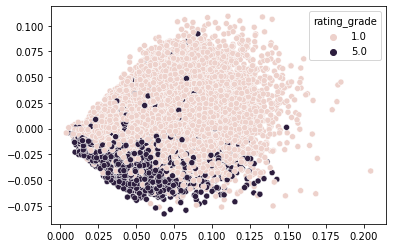

In [79]:
sns.scatterplot(svd[:,0], svd[:,1], hue=y_train)

In [80]:
y_test.value_counts()

1.0    14209
5.0     4421
Name: rating_grade, dtype: int64

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [82]:
accuracy_score(y_test, pipe.predict(X_test))

0.8012882447665056

In [83]:
f1_score(y_test, pipe.predict(X_test))

0.8813309398640851